<a href="https://colab.research.google.com/github/ANadalCardenas/attention/blob/main/Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

## Lab credit
Created by [Santiago Pascual](https://scholar.google.es/citations?user=7cVOyh0AAAAJ&hl=ca) and [Xavier Giro-i-Nieto](https://imatge.upc.edu/web/people/xavier-giro) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) in [UPC School](https://www.talent.upc.edu/ing/) (2019).

Updated by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) (2021), [Javier Ferrando](https://www.linkedin.com/in/javierferrandomonsonis/) (2022), and [Ioannis Tsiamas](https://www.linkedin.com/in/i-tsiamas/) (2023).


# The Fault in Our Time

This lab session introduces our beloved friends, the [recurrent neural networks (RNNs)](https://en.wikipedia.org/wiki/Recurrent_neural_network). Concretely, the topology we will be seeing is the Elman type, nowadays widely known plainly as RNN. Recurrent neural networks are the super cool queens of sequences: they know about order in sequences. As a quick test for how important sequential context is, and to prove that it is also very important for you... **CAN YOU TELL THE SIXTH DIGIT OF YOUR MOBILE PHONE NUMBER? WHAT PROCESS ARE YOU FOLLOWING TO RECALL IT?** Exactly, you went straight from the beginning of the full sequence, hence this is how important sequences are to us too :)

As in the example before, we always work with sequences when using RNNs. In each batch of data, we have as many elements as the length of the sequence (seq_len), and each of these elements can contain multiple features (num_feats):

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/rnn/images/input_batch.png?raw=true" class="center" title="input batch" width="300"/>
</p><br>

A fully connected layer is defined as:

$\boldsymbol{h}_t = \tanh(\boldsymbol{W}\boldsymbol{x}_t + \boldsymbol{b})$

With "only one" (but super important) change we formulate the RNN:

$\boldsymbol{h}_t = \tanh(\boldsymbol{W}\boldsymbol{x}_t + \boldsymbol{U}\boldsymbol{h}_{t-1} + \boldsymbol{b})$

Exactly, we added the matrix $\boldsymbol{U}$ which is a set of connections among all the neurons from the hidden layers to themselves (hence a feedback)!

This looks like the following, which is typically unrolled in time to show both flows of data, feed-forward ($\boldsymbol{W}$) + time ($\boldsymbol{U}$):

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/rnn/images/one_layer_rnn.png?raw=true" class="center" title="one layer RNN" width="300"/>
</p><br>

In [1]:
# Let's first import the typical stuff to play with deep nets
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import default_timer as timer

torch.manual_seed(1)
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

### Exercise 1: Building a recurrent neural layer

In the next cell, we will define our own unidirectional RNN layer. The class `MyUnidirectionalRNN` must make use of `nn.Linear` layers to make the feed-forward and time projections, and use the `nn.Parameter` class to build the biases. Please build the recurrent neural component with the addition of the recurrent connections.


In [2]:
class MyUnidirectionalRNN(nn.Module):

  def __init__(self, num_feats, rnn_size=128):
    super().__init__()
    self.rnn_size = rnn_size

    # Definition of the RNN parameters with the use of Linear layers:

    # Define the input activation matrix W
    self.W = nn.Linear(num_feats, rnn_size, bias=False)

    # TODO: Define the hidden activation matrix U
    self.U = nn.Linear(rnn_size, rnn_size, bias=False)

    # Define the bias
    self.b = nn.Parameter(torch.zeros(1, rnn_size))

  def forward(self, x, state=None):
    # Assuming x is of shape [batch_size, seq_len, num_feats]
    xs = torch.chunk(x, x.shape[1], dim=1)
    hts = []
    if state is None:
      state = self.init_state(x.shape[0])
    ht = state
    for xt in xs:
      # turn x[t] into shape [batch_size, num_feats] to be projected
      xt = xt.squeeze(1)
      # RNN formulation
      ht = F.tanh(self.W(xt) + self.U(ht) + self.b)
      # give the temporal dimension back to h[t] to be cated
      hts.append(ht.unsqueeze(1))
    hts = torch.cat(hts, dim=1)
    return hts

  def init_state(self, batch_size):
    return torch.zeros(batch_size, self.rnn_size)

# To correctly assess the answer, we build an example RNN with 10 inputs and 32 neurons
rnn = MyUnidirectionalRNN(10, 32)
# Then we will forward some random sequences, each of length 15
xt = torch.randn(5, 15, 10)
# The returned tensor will be h[t]
ht = rnn(xt)
assert ht.shape[0] == 5 and ht.shape[1] == 15 and ht.shape[2] == 32, \
'Something went wrong within the RNN :('
print('Success! Output shape: {} sequences, each of length {}, each '\
      'token with {} dims'.format(ht.shape[0], ht.shape[1], ht.shape[2]))

Success! Output shape: 5 sequences, each of length 15, each token with 32 dims


### But Why Would You Do That?

Congratz on finishing your first RNN definition! Now you should understand a bit more on the intrinsics of our sequential friends. But why would you define your own RNN? We didn't even operate with a GPU. We didn't even consider that possibility. So in the real world, we use PyTorch's `nn.RNN`, which allows for building a **stack of RNN layers directly**. Let's see some examples:

In [3]:
# we will work with 10 input features
NUM_FEATS = 10
# and sequences of length 25
SEQ_LEN = 25
# and 5 samples per batch
BATCH_SIZE = 5
# and 128 neurons
HIDDEN_SIZE = 128

# The first RNN contains a single layer
rnn1 = nn.RNN(NUM_FEATS, HIDDEN_SIZE)
print(rnn1)

# Now let's build a random input tensor to forward through it
xt = torch.randn(SEQ_LEN, BATCH_SIZE, NUM_FEATS)
ht, state = rnn1(xt)
print('Output h[t] tensor shape: ', ht.shape)
print('Output state tensor shape: ', state.shape)

RNN(10, 128)
Output h[t] tensor shape:  torch.Size([25, 5, 128])
Output state tensor shape:  torch.Size([1, 5, 128])


#### OK STOP IT HERE, We've got to talk

Think about how many things are happening in the previous cell. First, we define some hyper-parameters to define the input tensor shape and the RNN size. Then, we build one RNN layer. Then, we build random data. Finally, we forward the random data, and what is returned? Why does the input tensor `x` have that shape? Why is the RNN returning 2 output values?

**First answer:** The input data to an RNN can be shaped in 2 formats: `batch_first=True` and `batch_first=False`. As its name indicates, when it is `False`, the `batch_size` dimension is not the first but the second one. Then which is the first one? The `sequence_length`. If we do not specify anything, by default `batch_first=False`, so the tensor $\boldsymbol{x}_t$ must have the dimensions: [`seq_len`, `batch_size`, `num_feats`]. We normally use `batch_first=True` to couple the RNN easily with other layers like the `nn.Linear` one.

### Exercise 2

Find the second answer on "**Why is the RNN returning 2 output values?**". Understand what is the `state` output and answer: "**what does it contain?**". Your source of knowledge is in the following URL, where the outputs description for the `RNN` module is given: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN


Now we can continue defining some more examples of RNN layers as promised before

In [4]:
# 2 Layer RNN
rnn2 = nn.RNN(NUM_FEATS, HIDDEN_SIZE, num_layers=2)
ht, state = rnn2(xt)
print('RNN 2 layers >> ht.shape: ', ht.shape)
print('RNN 2 layers >> state.shape: ', state.shape)

# Batch Size first RNN
xt_bf = torch.randn(BATCH_SIZE, SEQ_LEN, NUM_FEATS)
rnn3 = nn.RNN(NUM_FEATS, HIDDEN_SIZE, num_layers=2, batch_first=True)
ht, state = rnn3(xt_bf)
print('RNN 2 layers, batch_first >> ht.shape: ', ht.shape)
print('RNN 2 layers, batch_first >> state.shape: ', state.shape)

RNN 2 layers >> ht.shape:  torch.Size([25, 5, 128])
RNN 2 layers >> state.shape:  torch.Size([2, 5, 128])
RNN 2 layers, batch_first >> ht.shape:  torch.Size([5, 25, 128])
RNN 2 layers, batch_first >> state.shape:  torch.Size([2, 5, 128])


<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/rnn/images/two_layers_rnn.png?raw=true" class="center" title="two layers RNN" width="300"/>
</p><br>

### Exercise 3.1
Build a **bidirectional RNN with 3 layers** by completing the TODO in the code.

In [5]:
# TODO: build the bidirectional RNN layer
bi_rnn = nn.RNN(NUM_FEATS, HIDDEN_SIZE, num_layers=3, batch_first=True, bidirectional=True)

# forward xt_bf
bi_ht, bi_state = bi_rnn(xt_bf)
print('Bidirectional RNN layer >> bi_ht.shape: ', bi_ht.shape)
print('Bidirectional RNN layer >> bi_state.shape: ', bi_state.shape)

Bidirectional RNN layer >> bi_ht.shape:  torch.Size([5, 25, 256])
Bidirectional RNN layer >> bi_state.shape:  torch.Size([6, 5, 128])


### Exercise 3.2
What is the output $\boldsymbol{h}_t$ shape and why?

### Exercise 3.3
What is the output `state` shape and why?.

### Hold The Gates! A Recurrent Re-Evolution

You've surely heard about the `LSTM` or the `GRU`, two practically sibling recurrent models. Well those are the actual RNNs you will use in your everyday. Why? Because they:
1. Improve the memory capacity of the RNN.
2. Improve the gradient flow of vanilla RNNs thanks to the learnable gate mechanisms.

An LSTM or GRU cell is a composition of different neurons working jointly, and the whole thing replaces a single RNN neuron. The RNN cell (with one $\tanh$ neuron), the LSTM cell and the GRU cell are depicted in the following figure from [this article](https://www.google.com/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwiMiPbfoPHlAhUQCxoKHW9qA04Qjhx6BAgBEAI&url=http%3A%2F%2Fdprogrammer.org%2Frnn-lstm-gru&psig=AOvVaw3mU76KRvFfY9WiOF4N12ex&ust=1574080203478260):

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/blob/main/labs/rnn/images/RNN-vs-LSTM-vs-GRU.png?raw=true" class="center" title="two layers RNN" width="1000"/>
</p><br>

Now check that out. In the case of the LSTM, we have **two signals flowing in time** apart from the feed-forward input per time-step: $\boldsymbol{c}_t$ and $\boldsymbol{h}_t$. The first one is called the cumulative cell state. It basically will add everything it is "allowed to see" from the input, and will forget portions of it. This is unbounded. On the other hand, the output cell state $\boldsymbol{h}_t$ will be the final layer activation (what is allowed to come out of it). This is bounded [-1, 1].

### Exercise 4: An LSTM Character-based Language Model

In this final exercise we will train a language model that will work at the character level. This is, a neural network based on an RNN architecture that will complete language (textual) sequences.


Our dataset will be composed of scripts from the *Friends* TV show. Download the episode 1 trainset:

In [6]:
!wget -q https://raw.githubusercontent.com/telecombcn-dl/labs-all/master/labs/rnn/episode1_english.txt

In [7]:
# Let's prepare some synthetic data

def prepare_sequence(seq, char2idx, onehot=True):
    # convert sequence of words to indices
    idxs = [char2idx[c] for c in seq]
    idxs = torch.tensor(idxs, dtype=torch.long)
    if onehot:
      # conver to onehot (if input to network)
      ohs = F.one_hot(idxs, len(char2idx)).float()
      return ohs
    else:
      return idxs

with open('episode1_english.txt', 'r') as txt_f:
  training_data = [l.rstrip() for l in txt_f if l.rstrip() != '']

# merge the training data into one big text line
training_data = '$'.join(training_data)

# Assign a unique ID to each different character found in the training set
char2idx = {}
for c in training_data:
    if c not in char2idx:
        char2idx[c] = len(char2idx)
idx2char = dict((v, k) for k, v in char2idx.items())
VOCAB_SIZE = len(char2idx)
RNN_SIZE = 1024
MLP_SIZE = 2048
SEQ_LEN = 50
print('Number of found vocabulary tokens: ', VOCAB_SIZE)

Number of found vocabulary tokens:  67


##### Exercise 4.1
* What is the amount of outputs needed by the character prediction model?

##### Exercise 4.2
* What is the proper activation to plug on top of the MLP (if any)? (Note that we use [`NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) later on).

##### Exercise 4.3
* Finish the definition of the `CharLSTM` model to include a `nn.LSTM` layer, with `batch_first=True`, `vocab_size` inputs and `rnn_size` cells, and an MLP that projects the `rnn_size` to `mlp_size` with one `ReLU` hidden layer and then to the appropriate amount of outputs. Put a `Dropout(0.4)` after the `ReLU`.


In [11]:
class CharLSTM(nn.Module):

    def __init__(self, vocab_size, rnn_size, mlp_size):
        super().__init__()
        self.rnn_size = rnn_size

        # TODO: Define the LSTM
        self.lstm = nn.LSTM(
            input_size=vocab_size,
            hidden_size=rnn_size,
            batch_first=True
        )

        self.dout = nn.Dropout(0.4)

        # TODO: Create an MLP with a hidden layer of mlp_size neurons that maps
        # from the RNN hidden state space to the output space of vocab_size
        self.mlp = nn.Sequential(
          # Linear layer
          nn.Linear(rnn_size, mlp_size),
          # Activation function
          nn.ReLU(),
          # Dropout (0.4)
          nn.Dropout(0.4),
          # Linear layer
          nn.Linear(mlp_size, vocab_size),
          # Activation function
          nn.LogSoftmax()
        )

    def forward(self, sentence, state=None):
        bsz, slen, vocab = sentence.shape
        ht, state = self.lstm(sentence, state)
        ht = self.dout(ht)
        h = ht.contiguous().view(-1, self.rnn_size)
        logprob = self.mlp(h)
        return logprob, state

Test how the model performs when using randomly initialized weights and biases:

In [12]:
# Let's build an example model and see what the scores are before training
model = CharLSTM(VOCAB_SIZE, RNN_SIZE, MLP_SIZE)

# This should output crap as it is not trained, so a fixed random tag for everything

def gen_text(model, seed, char2idx, num_chars=150):
  model.eval()
  # Here we don't need to train, so the code is wrapped in torch.no_grad()
  with torch.no_grad():
      inputs = prepare_sequence(seed, char2idx)
      # fill the RNN memory with the seed sentence
      seed_pred, state = model(inputs.unsqueeze(0))
      # now begin looping with feedback char by char from the last prediction
      preds = seed
      curr_pred = torch.argmax(seed_pred[-1, :])
      curr_pred = idx2char[curr_pred.item()]
      preds += curr_pred
      for _ in range(num_chars):

        # TODO: Get the next char prediction from the model given the current prediction and current state
        char_idx = char2idx[curr_pred]
        inputs = torch.zeros(1, 1, len(char2idx))
        inputs[0, 0, char_idx] = 1.0
        curr_pred, state = model(inputs, state)

        curr_pred = torch.argmax(curr_pred[-1, :])
        curr_pred = idx2char[curr_pred.item()]
        if curr_pred == '$':
          # special token to add newline char
          preds += '\n'
        else:
          preds += curr_pred
      return preds


print(gen_text(model, 'Monica was ', char2idx))

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Monica was FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


Prepare the training data by defining the data batches:

In [13]:
BATCH_SIZE = 64
T = len(training_data)
CHUNK_SIZE = T // BATCH_SIZE
# let's first chunk the huge train sequence into BATCH_SIZE sub-sequences
trainset = [training_data[beg_i:end_i] \
            for beg_i, end_i in zip(range(0, T - CHUNK_SIZE, CHUNK_SIZE),
                                    range(CHUNK_SIZE, T, CHUNK_SIZE))]
print('Original training string len: ', T)
print('Sub-sequences len: ', CHUNK_SIZE)

# The way training works is the following:
# at each batch sampling from the trainset, we pick a portion of sequences
# continuous with a sliding window in time. Hence, each of the BATCH_SIZE sub-sequences
# in batch b[i] will continue in batch b[i + 1] in the same position of the batch dimension.
# This is called stateful sampling, where we train with consecutive windows of sequences
# We broke the long string into BATCH_SIZE subsequence, so we introduced BATCH_SIZE - 1
# discontinuities... YES. But we can assume that each sub-sequence is continuous in a long
# enough chunk so that those discontinuities are negligible.

Original training string len:  23149
Sub-sequences len:  361


##### Exercise 4.4

What is the length of the sliding window that will run over each of the training sub-sequences?

NOTE: it is defined as a hyper-parameter above. How is this related to the backpropagation through time (BPTT)?

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


------------------------------
They wand to the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with
------------------------------
Finished epoch 50 in 0.3 s: loss: 1.587183
------------------------------
They whink you re for her whink your on ther and then she ne toding to this guy wain.
Monica: Oh wait, wait, unless you hase and the chand the door and a pr
------------------------------
Finished epoch 100 in 0.3 s: loss: 0.295691
------------------------------
They whink you rub alr how you doey.
Ross: Ooh... What, I just tho gotta go, I got a date with Andrea--Angela--Andrea--Angela--Andrea--Angela--Andrea--Angel
------------------------------
Finished epoch 150 in 0.3 s: loss: 0.047934
------------------------------
They whink it wholkn what're you in to thing.
Joey: (cometting up and bots to be sore.)
Chandler: Plook, Ross, look. You're founing.]
Ross: C'mon, ut, caule
------------------------

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


------------------------------
They wercome it hat me now what to be ine!
Monica: (to Ros) Let me get you some coffee.
Ross: Thanks.
Phoebe: Ooh, I just pulled out four eyelahs.)
[Scene: 
------------------------------
Finished epoch 1450 in 0.3 s: loss: 0.006817
------------------------------


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


They was no like a head out of the window.)
[Cut to Rachel starts to pluck at the air just in hat washow you ou Lean I love with your socks on, but it isn't
------------------------------
Finished epoch 1500 in 0.3 s: loss: 0.003471
------------------------------
They we cendle be kitcher cream of you.
Monica: That's Paul's watch and goes thing out of a suw. Y'know, I mean, I always to Chandler are working as thaing 
------------------------------
Finished epoch 1550 in 0.3 s: loss: 0.005410
------------------------------
They was not that have abealy not that have auy! And met that's Paul.
Monica: Oh God, is it 6:3?
Rachel: Hey Mon, look what I just found on thelcome to the 
------------------------------
Finished epoch 1600 in 0.3 s: loss: 0.004481
------------------------------
They was now weat me and the this guy with a big hammer said you might be here watch!
Paul: So you wand Joey, (to Rachel) This is everybody, this is Rachel,
------------------------------
Finished epoch 1650 

Text(0, 0.5, 'NLLLoss')

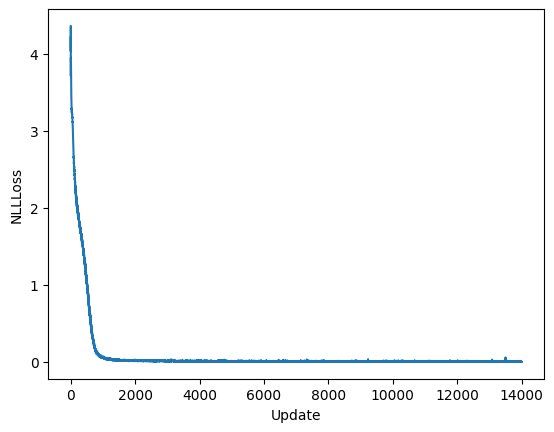

In [14]:
# Let's now build a model to train with its optimizer and loss
model = CharLSTM(VOCAB_SIZE, RNN_SIZE, MLP_SIZE)
model.to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 2000
tr_loss = []
state = None
timer_beg = timer()
for epoch in range(NUM_EPOCHS):
  model.train()
  # let's slide over our dataset
  for beg_t, end_t in zip(range(0, CHUNK_SIZE - SEQ_LEN - 1, SEQ_LEN + 1),
                          range(SEQ_LEN + 1, CHUNK_SIZE, SEQ_LEN + 1)):
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    optimizer.zero_grad()

    dataX = []
    dataY = []
    # Step 2. Get our inputs ready for the network, that is, turn them into
    # Tensors of one-hot sequences.
    for sent in trainset:
      # chunk the sentence
      chunk = sent[beg_t:end_t]

      # TODO: get X and Y with a shift of 1
      X = chunk[:-1]    # remove last char
      Y = chunk[1:]    # remove first char

      # convert each sequence to one-hots and labels respectively
      X = prepare_sequence(X, char2idx)
      Y = prepare_sequence(Y, char2idx, onehot=False)
      dataX.append(X.unsqueeze(0)) # create batch-dim
      dataY.append(Y.unsqueeze(0)) # create batch-dim
    dataX = torch.cat(dataX, dim=0).to(device)
    dataY = torch.cat(dataY, dim=0).to(device)

    # Step 3. Run our forward pass.
    # Forward through model and carry the previous state forward in time (statefulness)
    y_, state = model(dataX, state)
    # detach the previous state graph to not backprop gradients further than the BPTT span
    state = (state[0].detach(), # detach c[t]
             state[1].detach()) # detach h[t]

    # Step 4. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_function(y_, dataY.view(-1))
    loss.backward()
    optimizer.step()
    tr_loss.append(loss.item())
  timer_end = timer()
  if (epoch + 1) % 50 == 0:
    # Generate a seed sentence to play around
    model.to('cpu')
    print('-' * 30)
    print(gen_text(model, 'They ', char2idx))
    print('-' * 30)
    model.to(device)
    print('Finished epoch {} in {:.1f} s: loss: {:.6f}'.format(epoch + 1,
                                                               timer_end - timer_beg,
                                                               np.mean(tr_loss[-10:])))
  timer_beg = timer()

plt.plot(tr_loss)
plt.xlabel('Update')
plt.ylabel('NLLLoss')

Now that the generator of characters is trained, we can ask it to predict the rest of a sentence that begins with `Professor `:

In [15]:
print(gen_text(model.to('cpu'), 'Professor ', char2idx, 1000))

Professor sore maring when he istarting at me!
It's like it's like off.) (Chandler hits what he is working o fingrout woman for everybody, y'know? I mean what if you get through it?
Paul: Well, you might be here watch!
Paul: So you know how long it's been since I've grabbed a spoon? Do the words 'Billy, don't be a hero' mean, I had no wedathere my new furniture.]
Ross: I'm divorced!  I'm such I was Finging, I was Monica's geeky olde boothers!
Chandler: Oo, this is a Dear Diary moment.
Monica: Rach, wait, unless you a peane wothe wotch.
Monica: You and I have kinda drifted apart, but out, and that's when it hit me: how much Barry loks like Mr. Potato Head. Y'know, I mean, I always to just and that is why we don't do that grabing the best pare with this guys with a big hammer said you might be here watch!
Paul: So you know Poul like you gett her the big pipe organ, and shere's hat me and Chandler are coming over to her my me puy the anster in the park.
Joey: Look it was a job all right?


In [ ]:
Think of the RNN like this (2 layers, 3 time steps):

Layer 2:   h2(1) → h2(2) → h2(3)
             ↑       ↑       ↑
Layer 1:   h1(1) → h1(2) → h1(3)
             ↑       ↑       ↑
Input:      x(1)     x(2)     x(3)

What PyTorch returns:
🔹 h_t (output)
[h2(1), h2(2), h2(3)]


→ all time steps, last layer only

🔹 state
[
  h1(3),   # layer 1, last time step
  h2(3)    # layer 2, last time step
]

### References

[1] https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html